In [1]:
from grid_world import *
from stage2skeletonv3 import *
import random as rd

statespace_size = 15 # 3 (x,y) coords + a boolean (reached_a) + 8 neighbourhood booleans (presence of neighbours of opposite type - different reached_a)

gamma = 0.95
# epsilon = 1.0
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

def TD_target(reward, gamma, qMax):
    # done was an arg in skeleton
#   target = reward + gamma*(1-done)*qMax
    target = reward + gamma*qMax
    return target

action_set = {0: 'n', 1: 'e', 2: 's', 3: 'w'}

from collections import deque
from IPython.display import clear_output

epochs = 10000
mem_size = 2000
batch_size = 128
replay = deque(maxlen=mem_size)
max_moves = 400
h = 0
sync_freq = 250
j=0
losses=[]
rewards=[]
successes=0

model = prepare_torch()

n = 5
m = 5

num_agents = 4

successes = 0
collisions = 0

# main loop

for i in range(epochs):

    loc_a = ( rd.randint(0,n-1), rd.randint(0,m-1) )
    loc_b = ( rd.randint(0,n-1), rd.randint(0,m-1) )

    # ensuring loc_b and loc_a aren't equal
    while loc_b == loc_a:
        loc_b = ( rd.randint(0,n-1), rd.randint(0,m-1) )

    agents = init_agents(num_agents, loc_a, loc_b)

    a_b_switches = {}
    for agent in agents:
        a_b_switches[agent.id] = 0

    gw = GridWorld(n, m, loc_a, loc_b, agents)

    steps = 0
    loop = True
    episode_reward = 0
    epoch_successes = 0
    epoch_collisions = 0

    states1 = dict(zip([agent.id for agent in agents], [gw.get_np_state_for_agent(agent).reshape(1, statespace_size) for agent in agents]))

    while loop:

        # # change loop_agents to random order
        loop_agents = agents

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
        for agent in loop_agents:

            # print(steps)
            init_reached_a = agent.reached_a

            state1 = states1[agent.id]
            steps += 1
            j += 1
            qvals = get_qvals(state1)

            if (rd.random() < epsilon):
                action_ = rd.randint(0,3)
            else:
                action_ = np.argmax(qvals)
            
            action = action_set[action_]
            
            reward = gw.attempt_action_for_agent(agent, action)

            state2 = gw.get_np_state_for_agent(agent).reshape(1, statespace_size)

            episode_reward += reward

            if agent.reached_a != init_reached_a:
                a_b_switches[agent.id] += 1

            done = True if (a_b_switches[agent.id] >= 2) else False # both pickup and delivery at least once

            exp = (state1, action_, reward, state2, done)
            replay.append(exp)

            states1[agent.id] = state2

        success = True
        for sw in a_b_switches.values():
            # if there is at least one agent yet to do both pickup and dropoff in this loop iteration, do not count as a total success 
            if sw < 2:
                success = False
                break
        if success:
            successes += 1
            epoch_successes += 1
        
        if len(replay) > batch_size:

            minibatch = rd.sample(replay, batch_size)
            states = [s1 for (s1,a,r,s2,d) in minibatch]
            actions = [a for (s1,a,r,s2,d) in minibatch]
            targets = [TD_target(r, gamma, get_maxQ(s2)) for (_,_,r,s2,_) in minibatch]
            current_loss = train_one_step(states, actions, targets, gamma)
            losses.append(current_loss)
            print(i, "successes:", successes, " loss:", current_loss, "total collisions:", collisions, "epoch collisions:", epoch_collisions)
            print(f"episode reward: {episode_reward} steps: {steps} epoch successes: {epoch_successes} epsilon: {epsilon}")
            print()
            if j % sync_freq == 0:
                update_target()

        epoch_collisions = sum([agent.num_collisions for agent in loop_agents])

        # final - pending work
        # if (steps > max_moves) or (( collisions % 50 ) == 0):
        # debug
        # if (episode_reward >= 150) or (episode_reward <= -2000):
        if (epoch_successes >= 8) or (steps > max_moves) or \
        (( epoch_collisions % 10 ) == 0) :
            rewards.append(episode_reward)  
            loop = False
            steps = 0
        
        # end training if loss is under 30 after ~8000 epochs 
        if (i >= 8000) and (current_loss < 40):
            loop = False
            i = epochs-1
            break

        # debug
        # if steps == 500:
        #     loop = False
        #     break
    
    for agent in agents:
        collisions += agent.num_collisions

    clear_output(wait=True)

print(f"total steps in training: {j}, total collisions: {collisions}, total successes: {successes}")

### Runner skeleton
# 
# Runner should probably have agent-specific choose_action logic 
# 
# for each epoch, start with a gw
# for this gw, per each agent (in random order)...
#   get agent-specific "state" as state1 from gw (should have encoded neigbourhood values)
#   get qvals
#   get max qval and take the corresponding action for this agent
#   use reward returned by attempt_action...() to construct new state (state2) and store it back in the deque
#   state1 = state2, repeat for next random agent
# 
#

# class Runner:

#     def __init__(self, gw, agents):

#         self.gw = gw
#         self.agents = agents

#     def run(self):
#        pass


120 successes: 0  loss: 41.02168273925781 total collisions: 30 epoch collisions: 0
episode reward: -23 steps: 4 epoch successes: 0 epsilon: 0.4351424010585501

120 successes: 0  loss: 26.46563720703125 total collisions: 30 epoch collisions: 1
episode reward: -1 steps: 8 epoch successes: 0 epsilon: 0.43296668905325736

120 successes: 0  loss: 36.92570114135742 total collisions: 30 epoch collisions: 1
episode reward: -24 steps: 12 epoch successes: 0 epsilon: 0.43080185560799106

120 successes: 0  loss: 43.000728607177734 total collisions: 30 epoch collisions: 2
episode reward: -2 steps: 16 epoch successes: 0 epsilon: 0.4286478463299511

120 successes: 0  loss: 48.07890319824219 total collisions: 30 epoch collisions: 2
episode reward: -25 steps: 20 epoch successes: 0 epsilon: 0.42650460709830135

120 successes: 0  loss: 36.59640121459961 total collisions: 30 epoch collisions: 3
episode reward: -29 steps: 24 epoch successes: 0 epsilon: 0.42437208406280985

120 successes: 0  loss: 50.652004

KeyboardInterrupt: 

In [12]:
print(f"total steps in training: {j}, total collisions: {collisions}, total successes: {successes}")
print(f"latest loss: {losses[-1]}")

total steps in training: 116056, total collisions: 13202, total successes: 8331
latest loss: 64.63521575927734


<Figure size 1000x700 with 0 Axes>

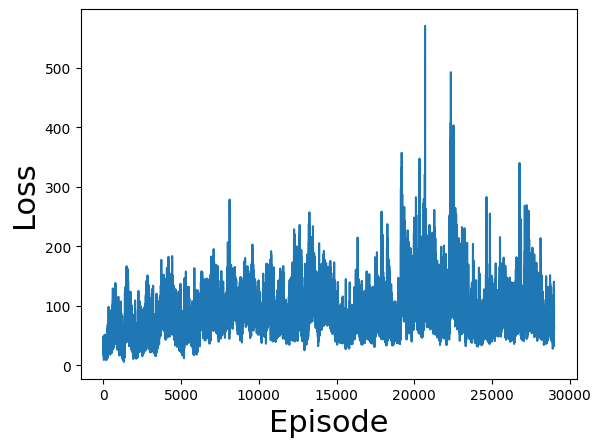

<Figure size 1000x700 with 0 Axes>

In [13]:
from matplotlib import pylab as plt

plt.xlabel("Episode",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.plot(np.array(losses))
plt.figure(figsize=(10,7))

In [4]:
print(losses[-1])

31.439138412475586


In [14]:
def test_once(model, loc_a, loc_b, display=True):

    n = 5
    m = 5

    max_steps = 25

    # 1st agent always begins at B
    agents = init_agents(4, loc_a, loc_b)

    gw = GridWorld(n, m, loc_a, loc_b, agents)

    focal_agent_idx = 0

    states_ = [gw.get_np_state_for_agent(agent).reshape(1, statespace_size) for agent in agents]
    states = [torch.from_numpy(state_).float() for state_ in states_]

    if display:
        print("initial state:")
        gw.display()
        print("focal agent is", agents[focal_agent_idx].id)

    for s in range( (len(agents)*25) + 1 ):

        for idx in range(len(agents)):

                qval = model(states[idx])
                qval_ = qval.data.numpy()
                action_ = np.argmax(qval_)
                action = action_set[action_]

                rew = gw.attempt_action_for_agent(agents[idx], action)

                if display:
                    print(f"agent {agents[idx].id} took action {action} and got rewarded {rew}")
                    print(gw.display())
                
                state_ = gw.get_np_state_for_agent(agents[idx]).reshape(1, statespace_size)
                state = torch.from_numpy(state_).float()
                states[idx] = state
        
        # whichever if condition is met first will return
        if (agents[focal_agent_idx].num_steps > max_steps):
            if display:
                print("test unsuccessful - too many steps")
            return False
        
        if (agents[focal_agent_idx].num_collisions > 0):
            if display:
                print("test unsuccessful - focal agent collided with an agent of the opposite type")
            return False

        if (agents[focal_agent_idx].reached_a):
            if display:
                print(f"test success - focal agent {agents[focal_agent_idx].id} reached A without collisions in under 25 steps")
            return True

    # ideally this line must never execute - if conditions should handle everything
    return False


In [15]:
loc_a = ( rd.randint(0,4), rd.randint(0,4) )
loc_b = ( rd.randint(0,4), rd.randint(0,4) )

test_once(model, loc_a, loc_b, True)

initial state:
 ----------------
|                |
|                |
|     A          |
|        B       |
|                |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
4 (2, 1) True | 1 (3, 2) False | 2 (3, 2) False | 3 (3, 2) False | 
focal agent is 1
agent 1 took action w and got rewarded -1
 ----------------
|                |
|                |
|     A          |
|    *1  B       |
|                |
 ----------------
* followed by a number indicates the presence of a number of agents in that cell.
agents at A and B are not indicated.

agents in the grid:
4 (2, 1) True | 1 (3, 1) False | 2 (3, 2) False | 3 (3, 2) False | 
None
agent 2 took action w and got rewarded -1
 ----------------
|                |
|                |
|     A          |
|    *2  B       |
|                |
 ----------------
* followed by a number indicates the presence of a number of agents in

True

In [18]:
def test_stats(model):
  max_games = 1000
  wins = 0
  for i in range(max_games):
      
      loc_a = ( rd.randint(0,4), rd.randint(0,4) )
      loc_b = ( rd.randint(0,4), rd.randint(0,4) )

      win = test_once(model, loc_a, loc_b, display=False)
      if win:
          wins += 1

  win_perc = float(wins) / float(max_games)
  print("Games played: {0}, # of wins: {1}".format(max_games,wins))
  print("Win percentage: {}".format(win_perc))


test_stats(model)

Games played: 1000, # of wins: 538
Win percentage: 0.538
